# Tutorial 12

## Outline

+ Transformer model

## Introduction

+ Paper: [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

+ MultiheadAttention:

$$ \mathrm{MultiheadAttention}(Q,K,V)=\mathrm{Concat(head_0,head_1,\cdots,head_h)}W^O $$

$$ \mathrm{head}_i=\mathrm{Attention}(QW_i^Q,KW_i^K,VW_i^V)$$

$$ \mathrm{Attention} = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

+ Transformer:

<img src='https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png' width="400" />

Positional encoding:

$$ \mathrm{PE}_{\mathrm{pos},2i} = \sin (\mathrm{pos} * 10000^{-2i / d}) $$

$$ \mathrm{PE}_{\mathrm{pos},2i+1} = \cos (\mathrm{pos} * 10000^{-2i / d}) $$

Feed forward NN:

$$ \mathrm{FFN}(x) = \mathrm{ReLU}(xW_1+b_1)W_2+b_2 $$

Masking: 

$$ \mathrm{Attention} = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}+M\right)V $$

For unwanted positions, apply a large negative value in $M$ to zero-out attention.

## PyTorch APIs:

+ [torch.nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention)
+ [torch.nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#transformer)
+ [torch.nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#transformerencoderlayer)
+ [torch.nn.TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html#transformerdecoderlayer) 


## Implement a MultiheadAttention Layer from scratch

In [1]:
import math
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from typing import Iterable, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, k_dim, v_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        assert k_dim % num_heads == 0, "k_dim can not be truly divied by num_heads"
        assert v_dim % num_heads == 0, "v_dim can not be truly divied by num_heads"
        
        k_proj_dim = k_dim // num_heads
        v_proj_dim = v_dim // num_heads
        
        self.sqrt_k_proj_dim = math.sqrt(k_proj_dim)
        
        self.query_projects = nn.ModuleList([
            nn.Linear(k_dim, k_proj_dim) for _ in range(num_heads)
        ])
        self.key_projects = nn.ModuleList([
            nn.Linear(k_dim, k_proj_dim) for _ in range(num_heads)
        ])
        self.value_projects = nn.ModuleList(
            nn.Linear(v_dim, v_proj_dim) for _ in range(num_heads)
        )
        self.final_project = nn.Linear(v_dim, dim)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, query, key, value):
        heads = []
        for i in range(self.num_heads):
            q_proj = self.query_projects[i](query)
            k_proj = self.key_projects[i](key)
            v_proj = self.value_projects[i](value)
            
            # batch_first
            scaled_dot_product = torch.matmul(q_proj, k_proj.transpose(-2,-1))
            scaled_dot_product /= self.sqrt_k_proj_dim
            head = torch.matmul(self.softmax(scaled_dot_product), v_proj)
            heads.append(head)
        
        out = self.final_project(torch.cat(heads, dim=-1))
        return out

In [5]:
dim = 128
k_dim = 512
v_dim = 256
num_heads = 4

batch_size = 10
seq_len = 5

query = torch.rand((batch_size, seq_len, k_dim))
key = torch.rand((batch_size, seq_len, k_dim))
value = torch.rand((batch_size, seq_len, v_dim))

attn = MultiheadAttention(dim, k_dim, v_dim, num_heads)
attn(query, key, value).shape

torch.Size([10, 5, 128])

## More challenging: English-French Translation

### Data Preparation

In [6]:
SOS_TOKEN, SOS_IDX = "[SOS]", 0
EOS_TOKEN, EOS_IDX = "[EOS]", 1
PAD_TOKEN, PAD_IDX = "[PAD]", 2
MAX_LEN = 9
DEVICE = 'cpu'

class Tokenizer:
    def __init__(self, name):
        self.name = name
        self.word2index = {
            SOS_TOKEN: SOS_IDX,
            EOS_TOKEN: EOS_IDX,
            PAD_TOKEN: PAD_IDX
        }
        self.word2count = {}
        self.index2word = {
            SOS_IDX: SOS_TOKEN,
            EOS_IDX: EOS_TOKEN,
            PAD_IDX: PAD_TOKEN
        }
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def tokenizeSentence(self, sentence):
        return [SOS_IDX] + [self.word2index[w] for w in sentence.split(' ')] + [EOS_IDX]
    
    def detokenizeSentence(self, tokens):
        return ' '.join(self.index2word[int(i)] for i in tokens).replace(EOS_TOKEN, "").replace(SOS_TOKEN, "").strip()
    
    
    
def get_raw_data(fname):
    src_raw = []
    tgt_raw = []
    with open(fname) as f:
        for line in f:
            src, tgt = line.strip('\n').split('\t')
            src_raw.append(src)
            tgt_raw.append(tgt)
    return np.array(src_raw), np.array(tgt_raw)


def init_tokenizer(src_raw, tgt_raw):
    src_tok = Tokenizer('src')
    tgt_tok = Tokenizer('tgt')
    for src, tgt in zip(src_raw, tgt_raw):
        src_tok.addSentence(src)
        tgt_tok.addSentence(tgt)
    return src_tok, tgt_tok


class Eng2FraDataset(Dataset):
    def __init__(self, src_raw, tgt_raw, src_tok, tgt_tok):
        super().__init__()
        self.src_raw = src_raw
        self.tgt_raw = tgt_raw
        
        self.src_data = [torch.tensor(src_tok.tokenizeSentence(src), dtype=torch.long) for src in src_raw]
        self.tgt_data = [torch.tensor(tgt_tok.tokenizeSentence(tgt), dtype=torch.long) for tgt in tgt_raw]
        
    def __getitem__(self, i):
        return self.src_data[i], self.tgt_data[i]
    
    def __len__(self):
        return len(self.src_data)


def collate_fn(batch):
    src = pad_sequence([b[0] for b in batch], padding_value=PAD_IDX)
    tgt = pad_sequence([b[1] for b in batch], padding_value=PAD_IDX)
    return src, tgt


src_raw, tgt_raw = get_raw_data("eng-fra-selected.txt")
src_tok, tgt_tok = init_tokenizer(src_raw, tgt_raw)

### Model definition

In [7]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 100):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src_emb, tgt_emb, 
            src_mask, tgt_mask, None,
            src_padding_mask, tgt_padding_mask, memory_key_padding_mask
        )
        return self.generator(outs)
    

    def encode(self, src: Tensor, src_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer.encoder(src_emb, src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer.decoder(tgt_emb, memory, tgt_mask)

In [10]:
src_vocab_size = src_tok.n_words
tgt_vocab_size = tgt_tok.n_words

emb_size = 128
nhead = 8
ffn_hidden_dim = 128

num_encoder_layers = 3
num_decoder_layers = 3

model = Seq2SeqTransformer(
    num_encoder_layers, num_decoder_layers, emb_size,
    nhead, src_vocab_size, tgt_vocab_size, ffn_hidden_dim
).to(DEVICE)

### Train

In [11]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [12]:
class Trainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, data, draw_curve=True):
        self.model.train()
        loader = DataLoader(data, self.batch_size, shuffle=True, collate_fn=collate_fn)
        loss_func = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        epoch_loss_list = []
        
        for i in tqdm(range(self.epoch)):
            num_data = 0
            epoch_loss = 0.0
            for src, tgt in loader:
                src = src.to(DEVICE)
                tgt = tgt.to(DEVICE)                
                tgt_input = tgt[:-1, :]

                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

                logits = self.model(
                    src, tgt_input, 
                    src_mask, tgt_mask, 
                    src_padding_mask, tgt_padding_mask, src_padding_mask
                )

                self.optimizer.zero_grad()

                tgt_out = tgt[1:, :]
                loss = loss_func(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
                loss.backward()

                self.optimizer.step()
                
                epoch_loss += loss.detach().cpu().numpy() * src.shape[1]
                num_data += src.shape[1]
            epoch_loss /= num_data
            epoch_loss_list.append(epoch_loss)
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            # ax.set_yscale("log")
            ax.plot(np.arange(len(epoch_loss_list)), epoch_loss_list)
            ax.set_xlabel("# Epoch")
            ax.set_ylabel("Loss")
        
        return epoch_loss_list



In [13]:
train_data = Eng2FraDataset(src_raw[:512], tgt_raw[:512], src_tok, tgt_tok)
trainer = Trainer(model, 256, 1e-3, 100, 0.0)

Seq2SeqTransformer - Number of parameters: 2429882


100%|█████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


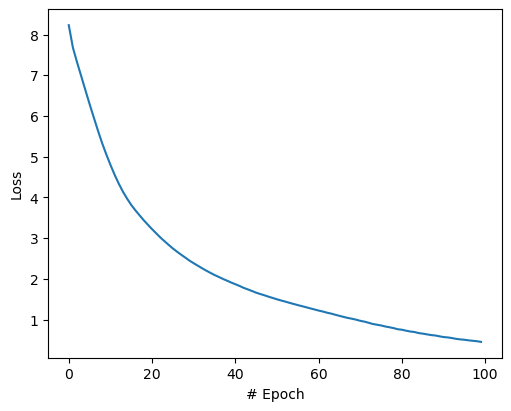

In [14]:
train_loss = trainer.train(train_data)

In [15]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = torch.tensor(src_tok.tokenizeSentence(src_sentence)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_IDX).flatten()
    return tgt_tok.detokenizeSentence([int(i) for i in tgt_tokens])

### Test

In [16]:
translate(trainer.model, 'i m ok')

'je vais bien'